In [1]:
import pandas as pd
df = pd.read_csv('data/accounts_post_processed_20190424.csv')

In [2]:
columns = ['transfer_operation', 'fill_order_operation']
#columns = ['total_ops', 'total_core_in_orders']
X = df.query('nb_assets_owned != 0 and lifetime_fees_paid != 0 and total_ops > 1')[columns].values

In [3]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline



pipe = Pipeline([('log', FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True) ),
                 ('scale', StandardScaler() )])
    
distributions = [
    ('Unscaled data', X),
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(X)),
#    ('Data after power transformation (Box-Cox)',
#     PowerTransformer(method='box-cox').fit_transform(X)),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('Data after sample-wise L2 normalizing',
        Normalizer().fit_transform(X)),
    ('Data after log + standard scaling', pipe.fit_transform(X))
]

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, 'plasma_r', cm.hot_r)

def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)


def plot_distribution(axes, X, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=5, lw=0)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

/home/zapata/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/zapata/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/zapata/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(axarr[0], X, hist_nbins=200,
                      x0_label=columns[0],
                      x1_label=columns[1],
         
                      title="Full data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], X[non_outliers_mask],
                      hist_nbins=50,
                      x0_label=columns[0],
                      x1_label=columns[1],
                      title="Zoom-in")

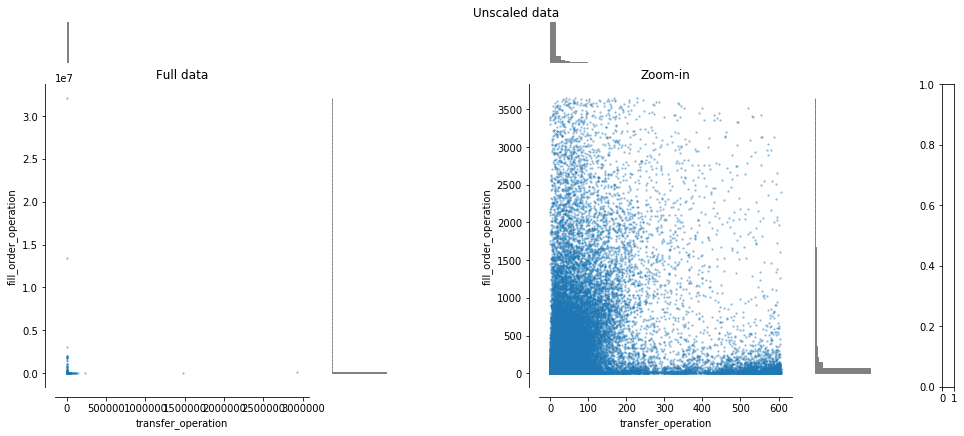

In [5]:
make_plot(0)

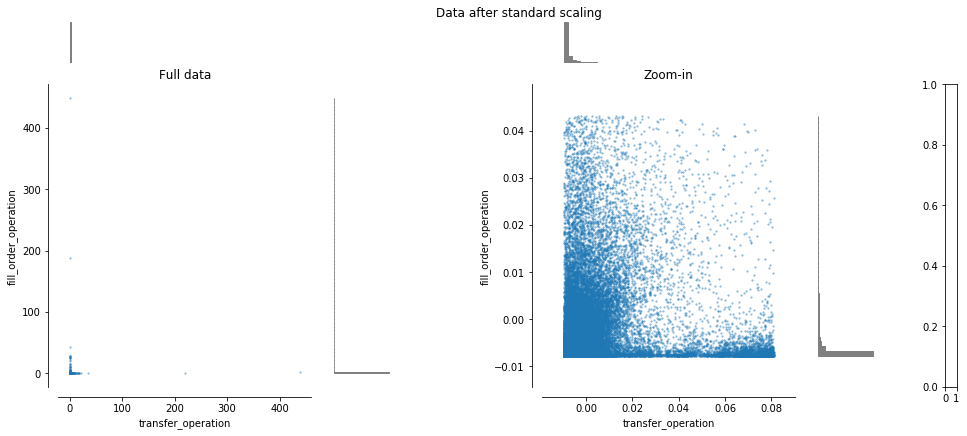

In [6]:
make_plot(1)

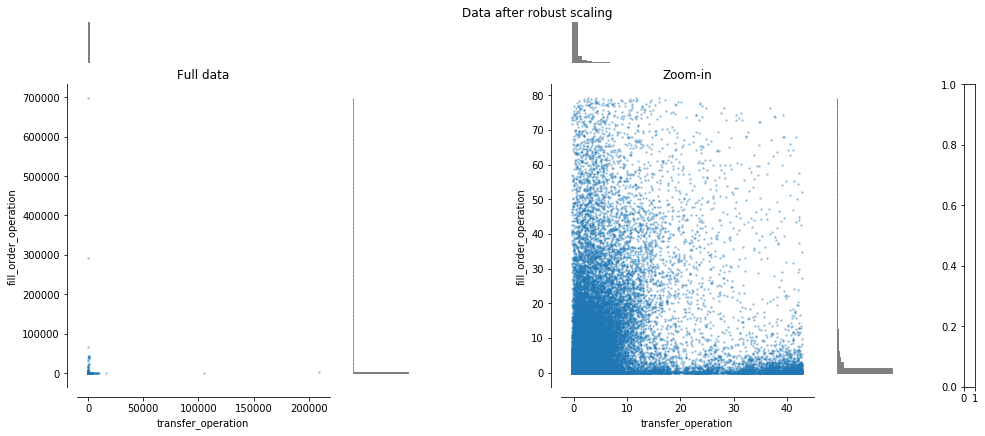

In [7]:
make_plot(4)

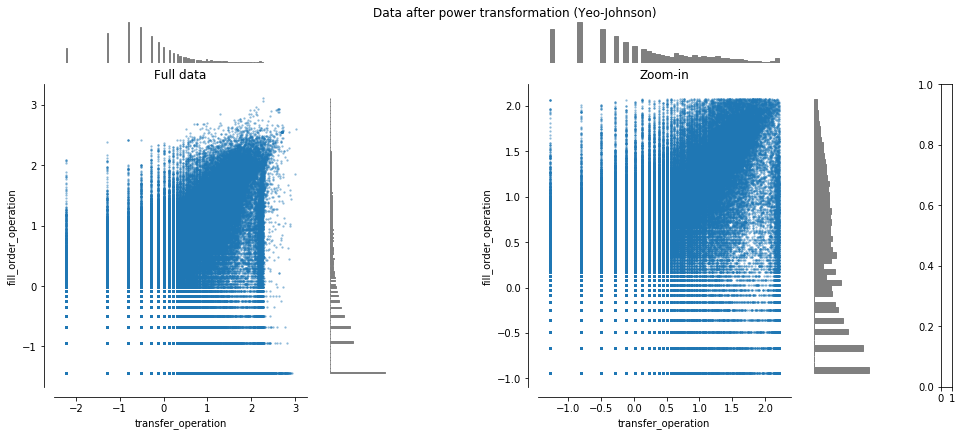

In [10]:
make_plot(5)

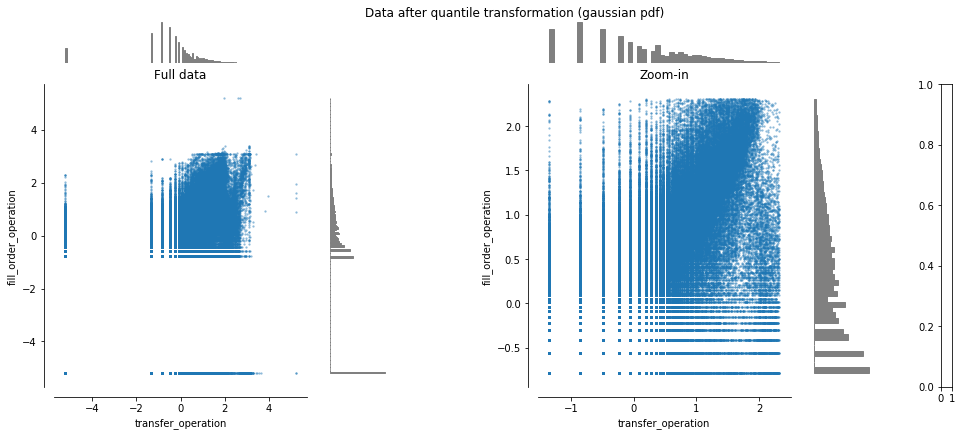

In [19]:
make_plot(6)

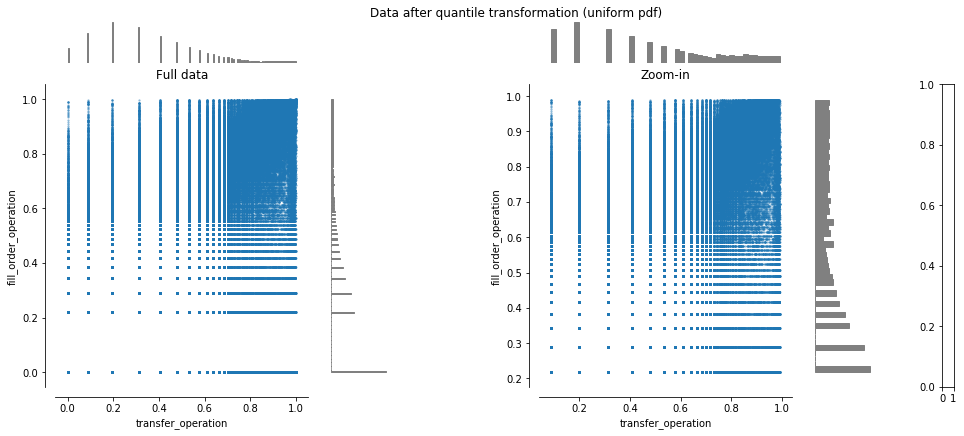

In [20]:
make_plot(7)

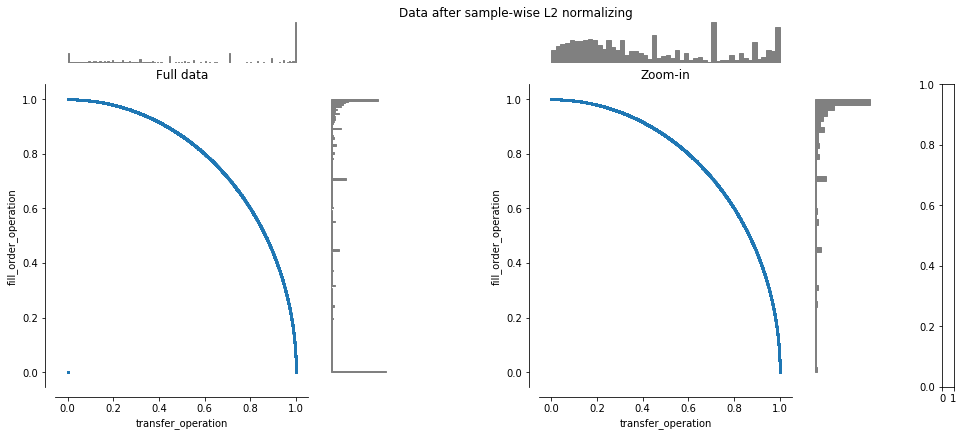

In [21]:
make_plot(8)

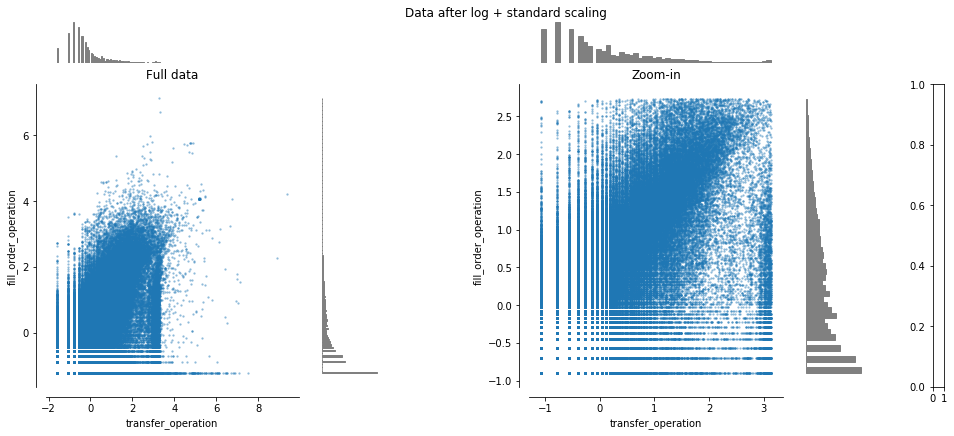

In [8]:
make_plot(9)